In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install tensorflow opencv-python matplotlib

In [5]:
import numpy as np
import pandas as pd
from pathlib import Path 
import os.path 
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

In [6]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

# **Train and Test Split**

In [7]:
dataset=datasets.ImageFolder(root=("/content/drive/MyDrive/Colab Notebooks/FoodCheck/Indian Food Images"),transform=transform)

In [8]:
class_names=dataset.classes
print(class_names)
print(len(class_names))

['adhirasam', 'aloo_gobi', 'aloo_matar', 'aloo_methi', 'aloo_shimla_mirch', 'aloo_tikki', 'anarsa', 'ariselu', 'bandar_laddu', 'basundi', 'bhatura', 'bhindi_masala', 'biryani', 'boondi', 'butter_chicken', 'chak_hao_kheer', 'cham_cham', 'chana_masala', 'chapati', 'chhena_kheeri', 'chicken_razala', 'chicken_tikka', 'chicken_tikka_masala', 'chikki', 'daal_baati_churma', 'daal_puri', 'dal_makhani', 'dal_tadka', 'dharwad_pedha', 'doodhpak', 'double_ka_meetha', 'dum_aloo', 'gajar_ka_halwa', 'gavvalu', 'ghevar', 'gulab_jamun', 'imarti', 'jalebi', 'kachori', 'kadai_paneer', 'kadhi_pakoda', 'kajjikaya', 'kakinada_khaja', 'kalakand', 'karela_bharta', 'kofta', 'kuzhi_paniyaram', 'lassi', 'ledikeni', 'litti_chokha', 'lyangcha', 'maach_jhol', 'makki_di_roti_sarson_da_saag', 'malapua', 'misi_roti', 'misti_doi', 'modak', 'mysore_pak', 'naan', 'navrattan_korma', 'palak_paneer', 'paneer_butter_masala', 'phirni', 'pithe', 'poha', 'poornalu', 'pootharekulu', 'qubani_ka_meetha', 'rabri', 'ras_malai', 'ras

In [9]:
torch.manual_seed(10)
test_size = len(dataset)//5
train_size = len(dataset) - test_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds) 

(3200, 800)

In [10]:
train_loader=DataLoader(train_ds,batch_size=10,shuffle=True)
test_loader=DataLoader(test_ds,batch_size=10)

# **Check Images and Labels**

In [11]:
for images, labels in train_loader:
    break
#print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im=make_grid(images,nrow=5)

Label: [63  0 37 17 68  3 19 13 73 12]
Class: pithe adhirasam jalebi chana_masala rabri aloo_methi chhena_kheeri boondi sheer_korma biryani


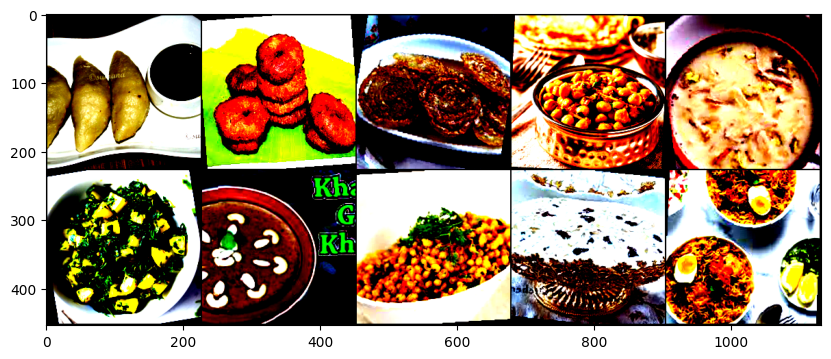

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [13]:
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                    std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

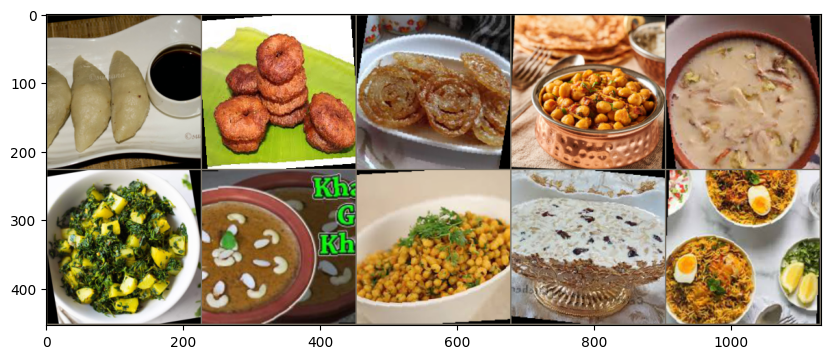

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

# **CNN Model**

In [15]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,3,1)
        self.conv2=nn.Conv2d(6,16,3,1)
        self.fc1=nn.Linear(16*54*54,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,20)
        self.fc4=nn.Linear(20,len(class_names))
        
    def forward(self,X):
        #print(X.shape)#torch.Size([10,3,224,224])
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,16*54*54)
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=F.relu(self.fc3(X))
        X=self.fc4(X)
        X=F.log_softmax(X,dim=1)     
        #print(X.shape)#torch.Size([10,80])
        return X

In [16]:
mycnn=MyCNN()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(mycnn.parameters(),lr=0.001)

In [17]:
mycnn

MyCNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=80, bias=True)
)

In [18]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
count_parameters(mycnn)

     162
       6
     864
      16
 5598720
     120
   10080
      84
    1680
      20
    1600
      80
________
 5613432


In [20]:
import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]
epochs=30

for i in range(epochs):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1                                            
        y_pred=mycnn(X_train)
        loss=criterion(y_pred,y_train)
        #true predictions
        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+=batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200==0:
            print(f"epoch: {i} loss: {loss.item} batch: {b} accuracy: {trn_corr.item()*100/(10*b):7.3f}%")
    loss=loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            y_val=mycnn(X_test)
            loss=criterion(y_val,y_test)
            
            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr
            
        loss=loss.detach().numpy()
        test_losses.append(loss)
        test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch: 0 loss: <built-in method item of Tensor object at 0x7eff02995990> batch: 200 accuracy:  60.400%
epoch: 1 loss: <built-in method item of Tensor object at 0x7eff02995a30> batch: 200 accuracy:  62.800%
epoch: 2 loss: <built-in method item of Tensor object at 0x7eff005804f0> batch: 200 accuracy:  64.500%
epoch: 3 loss: <built-in method item of Tensor object at 0x7eff006d7100> batch: 200 accuracy:  64.950%
epoch: 4 loss: <built-in method item of Tensor object at 0x7eff00580ea0> batch: 200 accuracy:  67.300%
epoch: 5 loss: <built-in method item of Tensor object at 0x7eff006dda80> batch: 200 accuracy:  68.050%
epoch: 6 loss: <built-in method item of Tensor object at 0x7eff005804f0> batch: 200 accuracy:  68.650%
epoch: 7 loss: <built-in method item of Tensor object at 0x7eff00580fe0> batch: 200 accuracy:  69.250%
epoch: 8 loss: <built-in method item of Tensor object at 0x7eff006d4860> batch: 200 accuracy:  68.350%
epoch: 9 loss: <built-in method item of Tensor object at 0x7eff005804f0> 

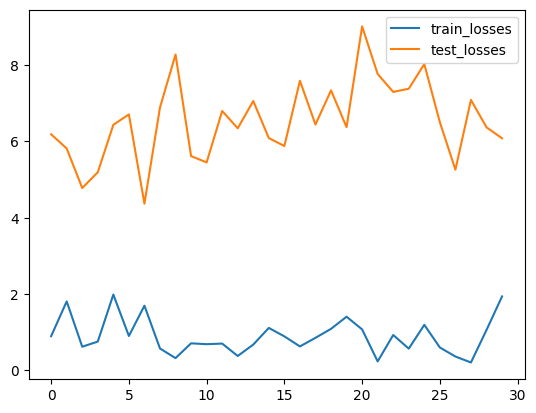

In [21]:
plt.plot(train_losses,label="train_losses")
plt.plot(test_losses,label="test_losses")
plt.legend()

# AlexNetModel

In [22]:
alex= models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 53.7MB/s]


In [23]:
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
for param in alex.parameters():
    param.requires_grad=False

In [25]:
torch.manual_seed(42)

alex.classifier=nn.Sequential(nn.Linear(9216,1024),
                                     nn.ReLU(),
                                     nn.Dropout(p=0.5),
                                     nn.Linear(1024,80),
                                     nn.LogSoftmax(dim=1))
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [26]:
count_parameters(alex)

 9437184
    1024
   81920
      80
________
 9520208


In [27]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(alex.classifier.parameters(),lr=0.001)

In [1]:
import time
start_time=time.time()
train_losses=[]
test_losses=[]
trn_correct=[]
tst_correct=[]

epochs=30
for i in range(epochs):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1
        
        y_pred=alex(X_train)
        loss=criterion(y_pred,y_train)       
        #Update parameters
        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+= batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200==0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    
    loss=loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)
                  
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            b+=1
                  
            y_val=alex(X_test)
            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr

    loss=criterion(y_val,y_test)
    loss=loss.detach().numpy()
    test_losses.append(loss)
    test_correct.append(tst_corr)
                  
print(f'\nDuration: {time.time() - start_time:.0f} seconds')   

NameError: ignored

NameError: ignored

# Prediction

In [ ]:
device = torch.device("cpu")   #"cuda:0"

In [ ]:
mycnn.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = mycnn(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(y_pred[0:5])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

In [ ]:
alex.eval()
ay_true=[]
ay_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = alex(test_images).argmax(dim=1)
        for i in range(len(pred)):
            ay_true.append(test_labels[i].item())
            ay_pred.append(pred[i].item())
print(ay_pred[0:5])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ay_true,ay_pred,target_names=class_names,digits=4))